# Bayesian Reaction Optimization and Regression using Dragonfly

This notebook contains code that demonstrates:
- Single- and multi-objective optimization using the Dragonfly Bayesian optimization library
- Gaussian process (GP) regression to experimental data
- Visualization of GP model predictions as response surfaces

The Dragonfly library was originally developed by Kandasamy et al. (J. Mach. Learn. Res. 2020, 21, 1–25, https://jmlr.org/papers/volume21/18-223/18-223.pdf) and is available as a Python library (https://github.com/dragonfly/dragonfly/).

## 1. Import required modules

In [1]:
# Required for Dragonfly (note: ignore Fortran warning)
import numpy as np
from argparse import Namespace
from dragonfly import load_config
from dragonfly.exd import domains
from dragonfly.exd.experiment_caller import CPFunctionCaller, CPMultiFunctionCaller
from dragonfly.opt.gp_bandit import CPGPBandit
from dragonfly.opt.multiobjective_gp_bandit import CPMultiObjectiveGPBandit
from dragonfly.exd.worker_manager import SyntheticWorkerManager

# Utilities
import pandas as pd
import math
import csv
import matplotlib.pyplot as plt # for plotting

C:\Users\Chemeng1\AppData\Local\conda\conda\envs\opt\lib\site-packages\dragonfly\utils\oper_utils.py:30: UserWarning: cannot import name 'direct' from 'dragonfly.utils.direct_fortran' (C:\Users\Chemeng1\AppData\Local\conda\conda\envs\opt\lib\site-packages\dragonfly\utils\direct_fortran\__init__.py)
Could not import Fortran direct library. Dragonfly can still be used, but might be slightly slower. To get rid of this warning, install a numpy compatible Fortran compiler (e.g. gfortran) and the python-dev package and reinstall Dragonfly.
  warn('%s\n%s'%(e, fortran_err_msg))


## 2. Simulate reaction

To simulate an optimization campaign, let's assume we have a model reaction where:

A $\rightarrow$ B

with 1st order kinetics where the yield depends on temperature, time, and solvent.

In [11]:
def reaction_simulator(x, objectives='single'):
    
    # x (list): [temperature (float), time (float), solvent (str)]
    T, t, solv = x[0], x[1], x[2]
    
    # For sake of demo, assume 1st order kinetics
    R = 8.314 # kJ/mol
    A = 5e8 # prefactor (min-1)
    Ea = 65 # activation energy (kJ/mol)
    k = A*math.exp(-( Ea )*1e3/(R*(T+273.15)))
    
    # Simulate a slower reaction rate with solvent B
    if solv == 'B':
        k = k/2
    
    # Yield equation for 1st order kinetics
    yield_val = ( 1 - math.exp(-k*t) ) * 100
    
    # Calculate throughput
    throughput = yield_val / t
    
    # Return results
    if objectives == 'single':
        return yield_val
    elif objectives == 'multi':
        return [yield_val, throughput]
    

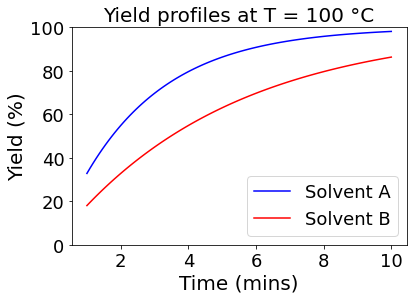

In [4]:
# Visualize yield profiles
T = 100 # highest temp
solvents = ['A','B']
ts = np.linspace(1, 10, 100).tolist()
yield_vals = np.zeros((2, len(ts)))

for i, solv in enumerate(solvents):
    for j, t in enumerate(ts):
        x = [T, t, solv]
        y = reaction_simulator(x)
        yield_vals[i,j] = y
        
# Plot
plt.figure()
plt.plot(ts, yield_vals[0,:], '-', color='b')
plt.plot(ts, yield_vals[1,:], '-', color='r')
plt.xlabel("Time (mins)", fontsize=20)
plt.ylabel("Yield (%)", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(0,100)
plt.title('Yield profiles at T = 100 \N{DEGREE SIGN}C', fontsize=20)
plt.legend(['Solvent A', 'Solvent B'], loc='lower right', fontsize=18)
plt.show()

## 3. Define optimization variables

In [2]:
# Define variables
variables = [   {'name': 'temperature', 'type': 'float',  'min': 40, 'max': 100}, # continuous
                {'name': 'time', 'type': 'float',  'min': 1, 'max': 10},          # continuous
                {'name': 'solvent', 'type': 'discrete', 'items': ['A', 'B']}      # discrete
                ]

# Create domain from variables
config_params = {'domain': variables}
config = load_config(config_params)

## 4. Single-objective optimization (yield)

expt #: 1 , x: [73.76117275180833, 2.9369085926127956, 'A'] , y: 21.30261818779866
expt #: 2 , x: [50.16467859584956, 9.479166397387743, 'A'] , y: 13.86647548984995
expt #: 3 , x: [93.50633614598536, 4.89927553671189, 'A'] , y: 73.94660642356764
expt #: 4 , x: [76.82170804114753, 2.0655847985058466, 'B'] , y: 9.750831176499752
expt #: 5 , x: [83.33115111135919, 7.939589380965335, 'A'] , y: 69.45497272762378
expt #: 6 , x: [47.75474420424784, 4.201586460552698, 'B'] , y: 2.7211144295004597
expt #: 7 , x: [63.0611500435692, 7.395469887369375, 'A'] , y: 25.505384829997357
expt #: 8 , x: [70.68754448599137, 2.637889395157151, 'B'] , y: 8.419766442286303
expt #: 9 , x: [88.76306377365779, 1.3347942115495544, 'A'] , y: 24.202512684350307
expt #: 10 , x: [98.12426420094722, 8.305681714611246, 'A'] , y: 94.88359863543869
expt #: 11 , x: [100.0, 10.0, 'A'] , y: 98.12914331868546
expt #: 12 , x: [100.0, 10.0, 'A'] , y: 98.12914331868546
expt #: 13 , x: [100.0, 9.232228323924804, 'A'] , y: 97.460

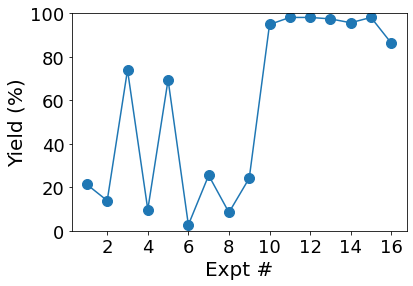

In [9]:
# User settings
num_init = 8 # number of initialization experiments
num_total = 16 # number of total experiments to perform
batch_size = 1 # number of new experiments you want to query at each iteration

# Specify algorithm settings
options = Namespace(
    build_new_model_every = batch_size,           # set to batch size
    init_capital = num_init-1,                    # number of initialization experiments (-1 is included since Dragonfly generates n+1 expts)
    gpb_hp_tune_criterion = 'ml-post_sampling',   # Criterion for tuning GP hyperparameters. Options: 'ml-post_sampling' (algorithm default), 'ml', 'post_sampling'.
    )

# Create optimizer object
func_caller = CPFunctionCaller(None, config.domain, domain_orderings=config.domain_orderings)
opt = CPGPBandit(func_caller, 'default', ask_tell_mode=True, options=options)

# ------------ Initialization phase ------------

opt.initialise() # this generates initialization points
init_expts = opt.ask(num_init) # get all initialization points

# Note: To provide your own initialization data to the algorithm,
# execute the above 2 lines (which clear the initial experiments generated by the algorithm)
# and return as many data points as you want in the for loop below.

# Run each experiment 
for x in init_expts: # x is a list of conditions
    y = reaction_simulator(x) # simulate reaction
    opt.tell([(x, y)]) # return result to algorithm
    opt.step_idx += 1 # increment experiment number
    print("expt #:", opt.step_idx, ", x:", x, ", y:", y)

# Update model using results
opt._build_new_model() # key line! update model using prior results
opt._set_next_gp() # key line! set next GP

# ------------ Refinement phase ------------

# While experiment budget has not been exceeded
while opt.step_idx < num_total:
    
    # Get a new batch of experiments
    batch = []
    for i in range(batch_size):
        x = opt.ask()
        batch.append(x)
    
    # Run each experiment
    for x in batch:
        y = reaction_simulator(x)
        opt.tell([(x, y)])
        opt.step_idx += 1
        print("expt #:", opt.step_idx, ", x:", x, ", y:", y)
    
    # Update model
    opt._build_new_model()
    opt._set_next_gp()
    
print('Max experiments reached')

# ------------ Plot results ------------

# Note: The opt object stores the results (opt.history.query_true_vals and opt.history.query_points)

yield_vals = np.array(opt.history.query_true_vals)
expt_num = np.arange(1,yield_vals.size+1)
plt.figure()
plt.plot(expt_num, yield_vals, 'o-', markersize=10)
plt.xlabel("Expt #", fontsize=20)
plt.ylabel("Yield (%)", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(0,100)
plt.show()

## 5. Multi-objective optimization (yield & throughput)

expt #: 1 , x: [88.10886031769927, 8.981657357956308, 'A'] , y: [83.35515887143981, 9.28059884154905]
expt #: 2 , x: [67.88704474337334, 5.1275972883343, 'B'] , y: [13.22477364993835, 2.579136563634937]
expt #: 3 , x: [44.12103401890418, 1.4650346578155369, 'A'] , y: [1.4449455935328204, 0.9862876525305752]
expt #: 4 , x: [50.32399580349182, 3.132209905862525, 'B'] , y: [2.4648569509961304, 0.7869386232329714]
expt #: 5 , x: [63.102745236724054, 6.728686268874034, 'B'] , y: [12.570188168386231, 1.8681489470736914]
expt #: 6 , x: [81.01514846065382, 4.051783648971567, 'A'] , y: [40.80706406637764, 10.071382778973252]
expt #: 7 , x: [92.15063919836561, 7.450707649090694, 'A'] , y: [84.89060800858769, 11.393630243826301]
expt #: 8 , x: [86.98259275575316, 8.102199863164575, 'A'] , y: [77.94535588890244, 9.620270692564523]


C:\Users\Chemeng1\AppData\Local\conda\conda\envs\opt\lib\site-packages\dragonfly\utils\oper_utils.py:132: UserWarning: Attempted to use direct, but fortran library could not be imported. Using PDOO optimiser instead of direct.
  warn(report_str)


expt #: 9 , x: [99.97063263590982, 1.8587382654780742, 'A'] , y: [52.20892816405141, 28.088370016218008]
expt #: 10 , x: [96.52040062301094, 9.78127891408267, 'A'] , y: [95.90412254967244, 9.804865334286067]
expt #: 11 , x: [99.9279903563191, 1.2153500319813566, 'A'] , y: [38.2211251817651, 31.448656087542204]
expt #: 12 , x: [100.0, 1.0, 'A'] , y: [32.82556041726106, 32.82556041726106]
expt #: 13 , x: [100.0, 8.335138461094163, 'A'] , y: [96.37154411493057, 11.5620807698352]
expt #: 14 , x: [97.18972065128438, 9.9936456131107, 'A'] , y: [96.63505216655103, 9.669649686174097]
expt #: 15 , x: [93.16210405112258, 1.5445775168417244, 'B'] , y: [18.76419933031387, 12.148434847531624]
expt #: 16 , x: [96.69886992436943, 1.2143546375273995, 'A'] , y: [33.01856396200744, 27.190215231720103]
Max experiments reached


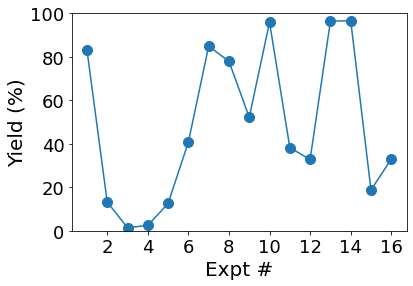

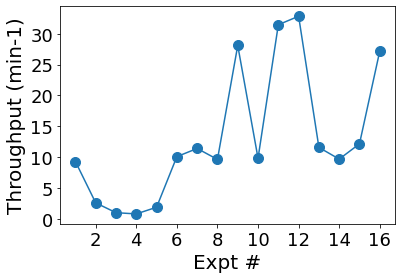

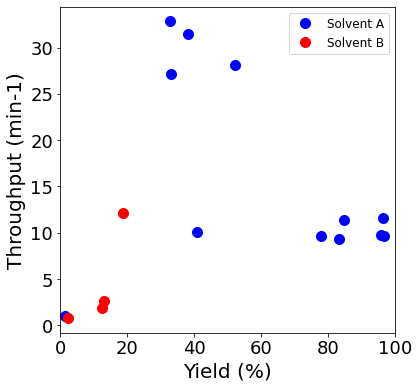

In [10]:
# User settings
num_init = 8 # number of initialization experiments
num_total = 16 # number of total experiments to perform
batch_size = 1 # number of new experiments you want to query at each iteration

# Specify algorithm settings
options = Namespace(
    build_new_model_every = batch_size,           # set to batch size
    init_capital = num_init-1,                    # number of initialization experiments (-1 is included since Dragonfly generates n+1 expts)
    gpb_hp_tune_criterion = 'ml-post_sampling',   # Criterion for tuning GP hyperparameters. Options: 'ml-post_sampling' (algorithm default), 'ml', 'post_sampling'.
    moors_scalarisation = 'linear',               # Scalarization approach for multi-objective opt. Options: 'linear' or 'tchebychev'
)

# Create optimizer object
func_caller = CPMultiFunctionCaller(None, config.domain, domain_orderings=config.domain_orderings)
func_caller.num_funcs = 2 # must specify how many functions are being optimized

wm = SyntheticWorkerManager(1)
opt = CPMultiObjectiveGPBandit(func_caller, wm, options=options)
opt.ask_tell_mode = True
opt.worker_manager = None
opt._set_up()

# ------------ Initialization phase ------------

opt.initialise() # this generates initialization points
init_expts = opt.ask(num_init) # get all initialization points

# Note: To provide your own initialization data to the algorithm,
# execute the above 2 lines (which clear the initial experiments generated by the algorithm)
# and return as many data points as you want in the for loop below.

# Run each experiment 
for x in init_expts: # x is a list of conditions
    y = reaction_simulator(x, objectives='multi') # simulate reaction, obtain yield and throughput values
    opt.tell([(x, y)]) # return result to algorithm
    opt.step_idx += 1 # increment experiment number
    print("expt #:", opt.step_idx, ", x:", x, ", y:", y)

# Update model using results
opt._build_new_model() # key line! update model using prior results
opt._set_next_gp() # key line! set next GP

# ------------ Refinement phase ------------

# While experiment budget has not been exceeded
while opt.step_idx < num_total:
    
    # Get a new batch of experiments
    batch = []
    for i in range(batch_size):
        x = opt.ask()
        batch.append(x)
    
    # Run each experiment
    for x in batch:
        y = reaction_simulator(x, objectives='multi')
        opt.tell([(x, y)])
        opt.step_idx += 1
        print("expt #:", opt.step_idx, ", x:", x, ", y:", y)
    
    # Update model
    opt._build_new_model()
    opt._set_next_gp()
    
print('Max experiments reached')

# ------------ Plot results ------------

# Note: The opt object stores the results (opt.history.query_true_vals and opt.history.query_points)

obj_vals = np.array(opt.history.query_true_vals)
yields = obj_vals[:,0]
throughputs = obj_vals[:,1]

# Plot yield vs. expt #
expt_num = np.arange(1,yields.size+1)
plt.figure()
plt.plot(expt_num, yields, 'o-', markersize=10)
plt.xlabel("Expt #", fontsize=20)
plt.ylabel("Yield (%)", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(0,100)
plt.show()

# Plot throughput vs. expt #
plt.figure()
plt.plot(expt_num, throughputs, 'o-', markersize=10)
plt.xlabel("Expt #", fontsize=20)
plt.ylabel("Throughput (min-1)", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

# Plot yield vs. throughput

# Get discrete candidates (solvent) for each point
solv_vals = np.zeros((yields.size))
for i, query in enumerate(opt.history.query_points):
    solv = 1 if query[1][0] == 'A' else 2
    solv_vals[i] = solv

solv1_idx = np.where(solv_vals == 1)
solv2_idx = np.where(solv_vals == 2)

solv1_objs = obj_vals[solv1_idx]
solv2_objs = obj_vals[solv2_idx]

# Plot
plt.figure(figsize=(6,6))
plt.plot(solv1_objs[:,0], solv1_objs[:,1], 'ob', markersize=10)
plt.plot(solv2_objs[:,0], solv2_objs[:,1], 'or', markersize=10)
plt.xlabel("Yield (%)", fontsize=20)
plt.ylabel("Throughput (min-1)", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(0,100)
plt.legend(['Solvent A', 'Solvent B'], loc='upper right', fontsize=12)
plt.show()

## 6. Generating Gaussian process models from data

The algorithm's Gaussian process model can be regressed to experimental data to enable predictions and visualize response surfaces.

This is demonstrated on an experimental dataset generated for an SNAr reaction.

In [32]:
snar_data = pd.read_csv('datasets\snar.csv')
snar_data

,expt #,type,leaving group,temperature (degC),time (mins),morpholine eq,base eq,yield (%),productivity (g/h),cost ($/mol)
0,1,initial,Cl,67,5.4,1.005,1.046,88.2,0.993,396
1,2,initial,Cl,104,6.3,1.186,1.189,96.9,0.934,403
2,3,initial,F,88,8.3,1.121,1.142,99.5,0.728,605
3,4,initial,F,56,9.4,1.030,1.001,99.5,0.643,580
4,5,initial,Br,117,3.2,1.057,1.109,95.0,1.804,481
5,6,initial,F,90,3.3,1.080,1.051,98.0,1.805,601
6,7,initial,Cl,76,7.1,1.149,1.076,95.9,0.821,392
7,8,initial,Br,48,2.0,1.151,1.170,84.3,2.563,566
8,9,initial,Br,108,4.5,1.054,1.062,95.7,1.293,474
9,10,refine,Br,113,1.0,1.054,1.113,91.9,5.586,497


In [43]:
# Extract data
n_data = len(snar_data)

# Reaction conditions evaluated
lg = snar_data['leaving group'].values
temp = snar_data['temperature (degC)'].values
time = snar_data['time (mins)'].values
morpho = snar_data['morpholine eq'].values
base = snar_data['base eq'].values

# Objective values
yields = snar_data['yield (%)'].values
prod = snar_data['productivity (g/h)'].values
cost = snar_data['cost ($/mol)'].values

# Convert to data format required by algorithm
X = [] # input values
Y = [] # objective values
for i in range(n_data):
    x = [lg[i], temp[i], time[i], morpho[i], base[i]]
    y = [yields[i], prod[i], cost[i]]
    X.append(x)
    Y.append(y)

In [46]:
# Define variables (same order as in 'X' object)
variables = [   {'name': 'leaving group', 'type': 'discrete',  'items': ['Cl', 'Br', 'F']},
                {'name': 'temperature', 'type': 'float',  'min': 40, 'max': 120},
                {'name': 'time', 'type': 'float',  'min': 1, 'max': 10},
                {'name': 'morpholine eq', 'type': 'float',  'min': 1, 'max': 1.2},
                {'name': 'base eq', 'type': 'float',  'min': 1, 'max': 1.2}
            ]

# Create domain from variables
config_params = {'domain': variables}
config = load_config(config_params)

# Set up Dragonfly optimizer object
num_init = 1 # specify any value
options = Namespace(
    gpb_hp_tune_criterion = 'ml',  # Criterion for tuning GP hyperparameters.
                                   # Options: 'ml' (maximum likelihood), 'post_sampling' (posterior sampling).
    )

func_caller = CPMultiFunctionCaller(None, config.domain, domain_orderings=config.domain_orderings)
func_caller.num_funcs = 3 # must specify number of objectives
wm = SyntheticWorkerManager(1)
opt = CPMultiObjectiveGPBandit(func_caller, wm, options=options)
opt.ask_tell_mode = True
opt.worker_manager = None
opt._set_up()

# ------------ Regress algorithm's Gaussian process (GP) model to data ------------

opt.initialise() # this generates initialization points
init_expts = opt.ask(num_init) # extract and discard all algorithm-generated initial points (will not be used)

# Return values from dataset to algorithm
for i in range(n_data):
    x = X[i]
    y = Y[i]
    opt.tell([(x, y)]) # return result to algorithm
    opt.step_idx += 1 # increment experiment number

# Update GP model using results
opt._build_new_model() # key line! update model using prior results
opt._set_next_gp() # key line! set next GP

# Extract GP models
gp_yield = opt.gps[0]
gp_productivity = opt.gps[1]
gp_cost = opt.gps[2]
print('GP models extracted')

# Note: for single objective optimization, create 'opt' object as in Section 4,
# discard algorithm-generated initial points, and extract GP model using 'gp = opt.gp'.


GP models extracted


In [66]:
# Code for obtaining model prediction given an input value x
x_raw = ['Cl', 120, 1, 1.1, 1.1]
x_input = [opt.func_caller.get_processed_domain_point_from_raw(x)]
# Note: above line converts raw input into data format required by algorithm's eval() function
# Input needs to be a list of points (note brackets above).

# Get model prediction (mean and std. dev.)
mu, stdev = gp_yield.eval(x_input, uncert_form='std')
print(mu, stdev)

[92.26192612] [1.28306708]


## 7. Visualizing model response surfaces

In [80]:
# By evaluating model over design space, response surfaces can be generated

# ------------ Obtain model predictions ------------

# Temp, time, leaving group will be varied, and morpholine and base equivalents will be fixed to enable visualization of surface
n_points = 100
T = np.linspace(40,120,n_points) # temp
t = np.linspace(1,10,n_points) # time
halides = np.array(['Cl','Br','F'])
morpho_eq = 1.1
base_eq = 1.1

# Get model prediction (mean, stdev) over grid of continuous variable values (temp, time)
x1, x2 = np.meshgrid(T, t, indexing='ij')
m = np.zeros((x1.shape[0], x1.shape[1], halides.shape[0])) # means
s = np.zeros(m.shape) # std. devs.

for i, T_val in enumerate(T): # loop over temperature range
    for j, t_val in enumerate(t): # loop over time range
        for k, halide in enumerate(halides): # loop over halides (discrete candidates)
            
            # Obtain and store model prediction
            x_raw = [halide, T_val, t_val, morpho_eq, base_eq]
            x_input = [opt.func_caller.get_processed_domain_point_from_raw(x_raw)]
            mean, stdev = gp_yield.eval(x_input, uncert_form='std')
            m[i,j,k] = mean[0]
            s[i,j,k] = stdev[0]

print('Predictions obtained over grid')

Predictions obtained over grid


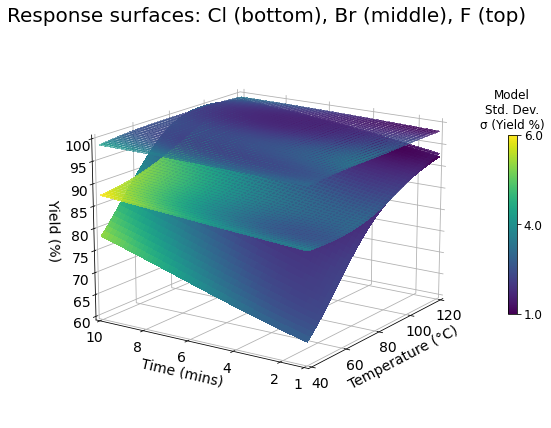

In [94]:
# ------------ Visualize model predictions as response surfaces ------------
            
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# Color surface according to local std. dev.
s_scaled = (s - np.min(s)) / (np.max(s) - np.min(s))
C = cm.viridis(s_scaled)

s_min = np.amin(s)
s_max = np.amax(s)
s_mid = (s_min+s_max)/2
unc = [s_min, s_mid, s_max]
uncs = [str(round(u)) for u in unc]

alphas = [1,0.8,0.6] # Cl,Br,F

# Plot surfaces
for i in range(3):
    p = ax.plot_surface(x1, x2, m[:,:,i], cmap='viridis', linewidth=0, edgecolor='none',\
                        antialiased=False, alpha=alphas[i], facecolors=C[:,:,i])
    
    # Plot colorbar
    if i == 0:
        c = plt.colorbar(p, ax=ax, pad=0.1, fraction=0.02, ticks=[0, 0.5, 1])
        c.ax.set_yticklabels(uncs, fontsize=12)
        c.ax.set_title('Model\nStd. Dev.\n{} (Yield %)'.format(u"\u03C3"), loc='center', fontsize=12)

# Axes
fsize = 14
ax.set_xlabel('Temperature ({}C)'.format(u"\N{DEGREE SIGN}"), fontsize=fsize, labelpad=2)
ax.set_ylabel('Time (mins)', fontsize=fsize, labelpad=2)
ax.set_zlabel('Yield (%)', fontsize=fsize, labelpad=2)

# Limits
xlim = [40,120]
ylim = [1,10]
zlim = [60,100]
ax.set_xlim3d(xlim)
ax.set_ylim3d(ylim)
ax.set_zlim3d(zlim)

# Ticks
ticksize = 14
ax.set_xticks([40,60,80,100,120])
ax.set_yticks([1,2,4,6,8,10])
ax.set_zticks(np.arange(60,105,5))
ax.xaxis.set_tick_params(labelsize=ticksize, pad=0)
ax.yaxis.set_tick_params(labelsize=ticksize, pad=0)
ax.zaxis.set_tick_params(labelsize=ticksize, pad=0)

# Set background color
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

plt.title('Response surfaces: Cl (bottom), Br (middle), F (top)', fontsize=20)
ax.view_init(16,-146)
plt.show()